# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re

from pyspark.ml import pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LinearSVC, NaiveBayes, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import CountVectorizer, IDF, StopWordsRemover, StringIndexer, Normalizer, RegexTokenizer, StandardScaler, VectorAssembler, PCA
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import avg, explode, concat, lit, min, max, split, udf, isnull, col, desc
from pyspark.sql import SparkSession, Window



In [2]:
# create a Spark session
##from lesson
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
sparkify_data='mini_sparkify_event_data.json'
df=spark.read.json(sparkify_data)
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [4]:
dfp=df.toPandas()
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


In [17]:
##Number of rows and columns in the dataset
len(df.columns) ##columns

18

In [18]:
df.count() ##rows

286500

In [21]:
##number of distinct users in the data
print("Distinct users:", df.select(['userId']).dropDuplicates().count())

Distinct users: 226


In [26]:
##number of sessions in the data
print("Number of sessions:", df.select(['sessionId']).dropDuplicates().count())

Number of sessions: 2354


In [4]:
##drop missing userIds and sessionIds
df = df.dropna(how='any', subset=['userId','sessionId'])

In [28]:
df.count()

286500

In [8]:
##identify empty userIds
dfp[dfp.userId == '']['userId'].count()

8346

In [5]:
##drop empty userIds
df= df[df.userId != ""]
df.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [32]:
dfp.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [43]:
##page interactions
df.groupby('page').count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



In [6]:
##creating a representation and timestamp column
new_ts= udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).strftime("%m-%d-%Y %H:%M:%S"))
df = df.withColumn('Updated_registration', new_ts('registration'))
df=df.withColumn('Updated_ts', new_ts('ts'))

In [7]:
#defining downgrade
downgrade_value= udf(lambda x:1 if x== "Submit Downgrade" else 0, IntegerType())
df=df.withColumn("downgrade_value", downgrade_value("page"))

##identify users who downgraded
dg_window=Window.partitionBy('userId')
df=df.withColumn("user_downgrade", max('downgrade_value').over(dg_window))

##defining churn
churn_value=udf(lambda x:1 if x== "Cancellation Confirmation" else 0, IntegerType())
df=df.withColumn("churn_value", churn_value("page"))

##identify users who churned
churn_window=Window.partitionBy('userId')
df=df.withColumn("user_churn", max('churn_value').over(churn_window))

In [8]:
## pandas dataframe for easy view
dfp=df.toPandas()
dfp.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,status,ts,userAgent,userId,Updated_registration,Updated_ts,downgrade_value,user_downgrade,churn_value,user_churn
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,09-27-2018 02:45:40,10-08-2018 12:58:54,0,0,0,0
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,09-27-2018 02:45:40,10-08-2018 13:02:16,0,0,0,0
2,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,09-27-2018 02:45:40,10-08-2018 13:05:32,0,0,0,0
3,None,Logged In,Darianna,F,3,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,09-27-2018 02:45:40,10-08-2018 13:05:33,0,0,0,0
4,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,09-27-2018 02:45:40,10-08-2018 13:09:55,0,0,0,0


In [12]:
##type/level of customers
df.groupby('level').count().show()

+-----+------+
|level| count|
+-----+------+
| free| 55721|
| paid|222433|
+-----+------+



In [9]:
## type/level(subscription) distribution between churn and regular users
df.drop_duplicates(['userId','level']).groupby(['user_churn','level']).count().sort("user_churn").show()

+----------+-----+-----+
|user_churn|level|count|
+----------+-----+-----+
|         0| free|  149|
|         0| paid|  129|
|         1| paid|   36|
|         1| free|   46|
+----------+-----+-----+



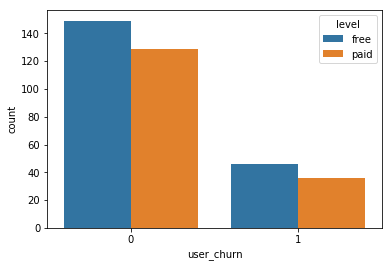

In [19]:
## graphical type/level(subscription) distribution between churn and regular users
df_churn_level= df.drop_duplicates(['userId','level']).groupby(['user_churn','level']).count().sort("user_churn").toPandas()
sns.barplot(x='user_churn', y='count', data=df_churn_level, hue='level')

Based on the barplot, it can be observed that free users are more likely to cancel subscription.

Text(0.5,1,'% of event occurence for active and cancelled users')

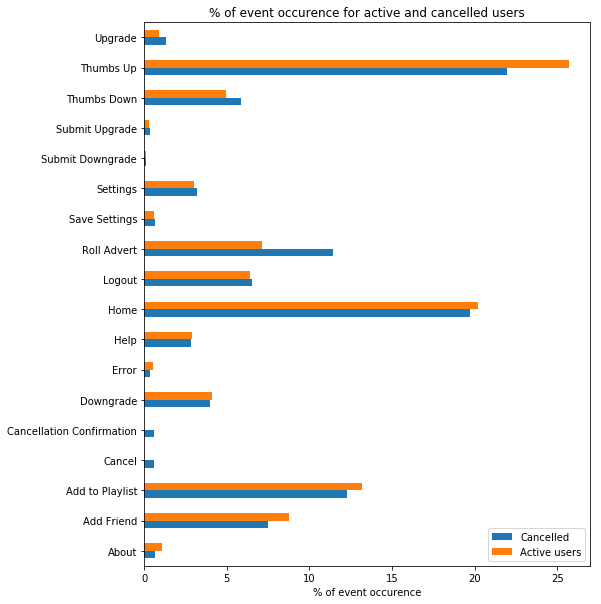

In [12]:
###Active vs Cancelled Users

users_1=dfp[dfp.user_churn==1].groupby(['page'])['userId'].count().drop('NextSong')
users_1=users_1/users_1.sum()*100

users_0=dfp[dfp.user_churn==0].groupby(['page'])['userId'].count().drop('NextSong')
users_0=users_0/users_0.sum()*100

users_df=pd.DataFrame({'Cancelled':users_1, 'Active users':users_0})
axis=users_df.plot(kind='barh', figsize=(8,10));
axis.set_xlabel('% of event occurence')
axis.set_title('% of event occurence for active and cancelled users')

Active users use features like Thumbs up , add to playlist  and add friends more than customers who end up cancelling their subscription with Sparkify. Demonstrating better and positive engagement. 

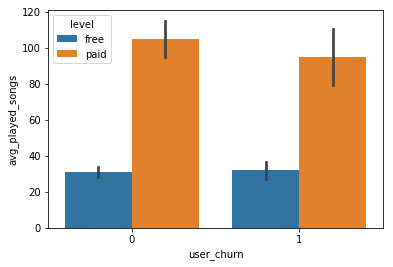

In [13]:
##number of songs played per session for free and paid users

total_songs_df= df.where('page=="NextSong"').groupby(['user_churn','userId','sessionId','level']).count()\
.groupby(['user_churn','userId','level']).agg({'count':'avg'})\
.withColumnRenamed('avg(count)','avg_played_songs').toPandas()

axis=sns.barplot(data=total_songs_df,x='user_churn',y='avg_played_songs',hue='level')

From the barplot, it is observed that paid users who don't churn listen to more number of songs per session compared to customers who churned.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

_I have created 9 features for the model below:_

In [10]:
##1- Number of songs listened to by customers
feature_1= df\
        .select('userId','song')\
        .groupby('userId')\
        .count()\
        .withColumnRenamed('count','total_songs')
feature_1.show()

+------+-----------+
|userId|total_songs|
+------+-----------+
|100010|        381|
|200002|        474|
|   125|         11|
|    51|       2464|
|   124|       4825|
|     7|        201|
|    54|       3437|
|    15|       2278|
|   155|       1002|
|   132|       2304|
|   154|        118|
|100014|        310|
|   101|       2149|
|    11|        848|
|   138|       2469|
|300017|       4428|
|    29|       3603|
|    69|       1342|
|100021|        319|
|    42|       4257|
+------+-----------+
only showing top 20 rows



In [11]:
##2- Number of thumbs up by customers
feature_2= df\
        .select('userId','page')\
        .where(df.page=='Thumbs Up')\
        .groupby('userId')\
        .count()\
        .withColumnRenamed('count','total_thumbs_up')
feature_2.show()

+------+---------------+
|userId|total_thumbs_up|
+------+---------------+
|100010|             17|
|200002|             21|
|    51|            100|
|   124|            171|
|     7|              7|
|    54|            163|
|    15|             81|
|   155|             58|
|   132|             96|
|   154|             11|
|100014|             17|
|   101|             86|
|    11|             40|
|   138|             95|
|300017|            303|
|    29|            154|
|    69|             72|
|100021|             11|
|    42|            166|
|   112|              9|
+------+---------------+
only showing top 20 rows



In [12]:
##3- Number of thumbs down by customers
feature_3= df\
        .select('userId','page')\
        .where(df.page=='Thumbs Down')\
        .groupby('userId')\
        .count()\
        .withColumnRenamed('count','total_thumbs_down')
feature_3.show()

+------+-----------------+
|userId|total_thumbs_down|
+------+-----------------+
|100010|                5|
|200002|                6|
|    51|               21|
|   124|               41|
|     7|                1|
|    15|               14|
|    54|               29|
|   155|                3|
|   132|               17|
|100014|                3|
|   101|               16|
|    11|                9|
|   138|               24|
|300017|               28|
|    29|               22|
|    69|                9|
|100021|                5|
|    42|               25|
|   112|                3|
|    73|                7|
+------+-----------------+
only showing top 20 rows



In [13]:
##4- Number of songs added
feature_4=df\
        .select('userId','page')\
        .where(df.page=='Add to Playlist')\
        .groupby('userId')\
        .count()\
        .withColumnRenamed('count','add_to_playlist')
feature_4.describe().show()

+-------+------------------+-----------------+
|summary|            userId|  add_to_playlist|
+-------+------------------+-----------------+
|  count|               215|              215|
|   mean| 66103.63720930232|30.35348837209302|
| stddev|106360.47999565038| 32.8520568555997|
|    min|                10|                1|
|    max|                99|              240|
+-------+------------------+-----------------+



In [14]:
##5- Number of friends added
feature_5=df\
        .select('userId','page')\
        .where(df.page=='Add Friend')\
        .groupby('userId')\
        .count()\
        .withColumnRenamed('count','add_friend')
feature_5.describe().show()

+-------+------------------+------------------+
|summary|            userId|        add_friend|
+-------+------------------+------------------+
|  count|               206|               206|
|   mean| 66076.91262135922|20.762135922330096|
| stddev|106860.60517425007|20.646779074405007|
|    min|                10|                 1|
|    max|                99|               143|
+-------+------------------+------------------+



In [15]:
##6- Time since registration
feature_6=df\
        .select('userId','registration','ts')\
        .withColumn('lifetime',(df.ts-df.registration))\
        .groupby('userId')\
        .agg({'lifetime':'max'})\
        .withColumnRenamed('max(lifetime)','lifetime')\
        .select('userId',(col('lifetime')/1000/3600/24).alias('lifetime'))
feature_6.describe().show()

+-------+------------------+-------------------+
|summary|            userId|           lifetime|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|   79.8456834876543|
| stddev|105396.47791907164|  37.66147001861254|
|    min|                10|0.31372685185185184|
|    max|                99|  256.3776736111111|
+-------+------------------+-------------------+



In [16]:
##7- Total length of listening
feature_7=df\
        .select('userId','length')\
        .groupby('userId')\
        .sum()\
        .withColumnRenamed('sum(length)', 'total_listening_time')
feature_7.describe().show()

+-------+------------------+--------------------+
|summary|            userId|total_listening_time|
+-------+------------------+--------------------+
|  count|               225|                 225|
|   mean|65391.013333333336|  252558.32065155543|
| stddev|105396.47791907164|   275396.4038847635|
|    min|                10|           691.66884|
|    max|                99|  1991154.9155799907|
+-------+------------------+--------------------+



In [17]:
##8- Gender 
feature_8=df\
        .select('userId','gender')\
        .dropDuplicates()\
        .replace(['F','M'],['0','1'],'gender')\
        .select('userId',col('gender').cast('int'))
feature_8.describe().show()

+-------+------------------+-------------------+
|summary|            userId|             gender|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.5377777777777778|
| stddev|105396.47791907165|0.49968243883744773|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [18]:
##9 - Number of artists the customer has listened to
feature_9=df\
        .filter(df.page=="NextSong")\
        .select('userId','artist')\
        .dropDuplicates()\
        .groupby('userId')\
        .count()\
        .withColumnRenamed('count', 'total_artist_played')
feature_9.describe().show()

+-------+------------------+-------------------+
|summary|            userId|total_artist_played|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|  696.3777777777777|
| stddev|105396.47791907164|  603.9518698630802|
|    min|                10|                  3|
|    max|                99|               3544|
+-------+------------------+-------------------+



In [30]:
##churn label
target=df.select('userId',col('user_churn').alias('target')).dropDuplicates()
target.show()

+------+------+
|userId|target|
+------+------+
|100010|     0|
|200002|     0|
|   125|     1|
|   124|     0|
|    51|     1|
|     7|     0|
|    15|     0|
|    54|     1|
|   155|     0|
|100014|     1|
|   132|     0|
|   154|     0|
|   101|     1|
|    11|     0|
|   138|     0|
|300017|     0|
|100021|     1|
|    29|     1|
|    69|     0|
|   112|     0|
+------+------+
only showing top 20 rows



In [31]:
##Merge all features and label together
data=feature_1.join(feature_2,'userId','inner')\
            .join(feature_3,'userId','inner')\
            .join(feature_4,'userId','inner')\
            .join(feature_5,'userId','inner')\
            .join(feature_6,'userId','inner')\
            .join(feature_7,'userId','inner')\
            .join(feature_8,'userId','inner')\
            .join(feature_9,'userId','inner')\
            .join(target,'userId','inner')\
            .drop('userId')\
            .fillna(0)

data.show(10)

+-----------+---------------+-----------------+---------------+----------+------------------+--------------------+------+-------------------+------+
|total_songs|total_thumbs_up|total_thumbs_down|add_to_playlist|add_friend|          lifetime|total_listening_time|gender|total_artist_played|target|
+-----------+---------------+-----------------+---------------+----------+------------------+--------------------+------+-------------------+------+
|        381|             17|                5|              7|         4|  55.6436574074074|   66940.89735000003|     0|                252|     0|
|        474|             21|                6|              8|         4| 70.07462962962963|   94008.87593999993|     1|                339|     0|
|       4825|            171|               41|            118|        74|131.55591435185184|  1012312.0927899999|     0|               2232|     0|
|       2464|            100|               21|             52|        28|19.455844907407407|   523275.842

In [88]:
final_data_pd=data.toPandas()

In [25]:
###checking for nulls
final_data_pd.isnull().sum() ##no nulls

total_songs             0
total_thumbs_up         0
total_thumbs_down       0
add_to_playlist         0
add_friend              0
lifetime                0
total_listening_time    0
gender                  0
total_artist_played     0
target                  0
dtype: int64

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [35]:
###vectorise the features
cols=["total_songs","total_thumbs_up","total_thumbs_down","add_to_playlist","add_friend",\
      "total_listening_time","total_artist_played","gender","lifetime"]
assembler=VectorAssembler(inputCols=cols, outputCol="NumFeatures")
data=assembler.transform(data)


In [37]:
data.show()

+-----------+---------------+-----------------+---------------+----------+------------------+--------------------+------+-------------------+------+--------------------+
|total_songs|total_thumbs_up|total_thumbs_down|add_to_playlist|add_friend|          lifetime|total_listening_time|gender|total_artist_played|target|         NumFeatures|
+-----------+---------------+-----------------+---------------+----------+------------------+--------------------+------+-------------------+------+--------------------+
|        381|             17|                5|              7|         4|  55.6436574074074|   66940.89735000003|     0|                252|     0|[381.0,17.0,5.0,7...|
|        474|             21|                6|              8|         4| 70.07462962962963|   94008.87593999993|     1|                339|     0|[474.0,21.0,6.0,8...|
|       4825|            171|               41|            118|        74|131.55591435185184|  1012312.0927899999|     0|               2232|     0|[4

In [38]:
##standardizing all input features 
scaler=StandardScaler(inputCol='NumFeatures',outputCol='newFeatures',withStd=True)
scaler_model=scaler.fit(data)
data=scaler_model.transform(data)

In [ ]:
data_1= data.select(data.target.alias("label"), data.newFeatures.alias("features"))

In [40]:
data_1.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.28303433540817...|
|    0|[0.35212145664954...|
|    0|[3.58435870956552...|
|    1|[1.83043727676051...|
|    0|[0.14931732655392...|
|    0|[1.69226303427777...|
|    1|[2.55325199684491...|
|    0|[0.74435801595536...|
|    1|[0.23029040413788...|
|    0|[1.71157771333450...|
|    1|[1.59643251126555...|
|    0|[0.62995568615783...|
|    0|[1.83415163811757...|
|    0|[3.28943841781474...|
|    1|[0.23697625458060...|
|    1|[2.67656879389939...|
|    0|[0.99693458823563...|
|    0|[0.21691870325246...|
|    0|[3.16240725940320...|
|    1|[0.33949262803553...|
+-----+--------------------+
only showing top 20 rows



In [41]:
#train test split
train, val= data_1.randomSplit([0.85,0.15],seed=42)
train=train.cache()

In [66]:
##Random Forest Classifier
rf=RandomForestClassifier()

feature1_eval=MulticlassClassificationEvaluator(metricName='f1')
param_grid=ParamGridBuilder().build()

cross_val_rf=CrossValidator(estimator=rf, estimatorParamMaps=param_grid, evaluator=feature1_eval, numFolds=3)

In [69]:
import datetime
from time import time 

In [71]:
start=time()
cv_model_rf=cross_val_rf.fit(train)
end=time()
cv_model_rf.avgMetrics
print("Time training took:{}".format(end-start))

Time training took:139.0088620185852


In [72]:
res_rf=cv_model_rf.transform(val)

In [73]:
##Evaluation metrics for Random Forest 
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
print("F-1 score for Random Forest Classifier:{}".format(evaluator.evaluate(res_rf,{evaluator.metricName : "accuracy"})))
print("Accuracy for Random Forest Classifier:{}".format(evaluator.evaluate(res_rf,{evaluator.metricName : "f1"})))

F-1 score for Random Forest Classifier:0.8260869565217391
Accuracy for Random Forest Classifier:0.8009661835748794


In [74]:
##Gradient Boost
gbt_clf=GBTClassifier(maxIter=10, seed=42)

feature1_eval=MulticlassClassificationEvaluator(metricName='f1')
param_grid=ParamGridBuilder().build()

cross_val_gbt=CrossValidator(estimator=gbt_clf, estimatorParamMaps=param_grid, evaluator=feature1_eval, numFolds=3)

In [75]:
start=time()
cv_model_gbt=cross_val_gbt.fit(train)
end=time()
cv_model_gbt.avgMetrics
print("Time training took:{}".format(end-start))

Time training took:636.4021620750427


In [76]:
res_gbt=cv_model_gbt.transform(val)

In [77]:
##Evaluation metrics for Gradient Boost
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
print("F-1 score for Gradient Boost:{}".format(evaluator.evaluate(res_gbt,{evaluator.metricName : "accuracy"})))
print("Accuracy for Gradient Boost:{}".format(evaluator.evaluate(res_gbt,{evaluator.metricName : "f1"})))

F-1 score for Gradient Boost:0.7391304347826086
Accuracy for Gradient Boost:0.7391304347826086


#### Model Comparison:

- Random Forest: Accuracy=0.8009, F1-score=0.826 and time taken=139.008 seconds
- Gradient Boost:  Accuracy=0.7391, F1-score=0.739 and time taken=636.40 seconds

Time taken difference is considerable and also since its a smaller dataset the performance difference is clearly evident between the two models. Thus, I will go ahead with Random Forest in this case and do some hyperparameter tuning to improve the model further.
    

#### Hyperparameter Tuning:

In [84]:
RandomForestClassifier(maxDepth=10,seed=42)

param_grid_rf=ParamGridBuilder().addGrid(rf.maxDepth,[5,10]).build()
feature1_eval=MulticlassClassificationEvaluator(metricName='f1')

cross_val_rf=CrossValidator(estimator=rf, estimatorParamMaps=param_grid_rf, evaluator=feature1_eval, numFolds=3)

In [85]:
cv_model_rf=cross_val_rf.fit(train)
cv_model_rf.avgMetrics

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/opt/spark-2.4.3-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'RandomForestClassifier' object has no attribute '_java_obj'


[0.8080422180613888, 0.7869331687463434]

In [86]:
##choosing parameters with best metrics
rf_best=RandomForestClassifier(seed=42,maxDepth=5)
rf_best_model=rf_best.fit(train)
results_final=rf_best_model.transform(val)

In [87]:
##final evaluation metrics
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
print("F-1 score for Random Forest Classifier:{}".format(evaluator.evaluate(results_final,{evaluator.metricName : "accuracy"})))
print("Accuracy for Random Forest Classifier:{}".format(evaluator.evaluate(results_final,{evaluator.metricName : "f1"})))

F-1 score for Random Forest Classifier:0.8260869565217391
Accuracy for Random Forest Classifier:0.8009661835748794


#### Feature Importance

Text(0.5,1,'Random Forest Feature Importance')

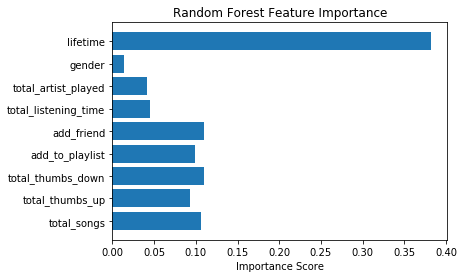

In [91]:
feat_imp=rf_best_model.featureImportances.values
y_pos=np.arange(len(cols))

plt.barh(y_pos, feat_imp, align='center')
plt.yticks(y_pos,cols)
plt.xlabel('Importance Score')
plt.title('Random Forest Feature Importance')

It is evident from the plot above that lifetime is an important factor.Following that, Adding Friends, Total songs played and  total thumbs down also look to be have an important bearing but not as much as lifetime.

#### Conclusion

I used two models to predict customers churn. I built 9 features for the model and selected 2 models: Random Forest and Gradient Boost. Finally, selecting RF for prediction. The RF model had an 80% accuracy with 0.826 F1 score. Also, investigating feature importance- Lifetime of the customer looks to be an important determinent in the data.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.